# Inpainting with ControlNet
This notebook contains examples of using a new `StableDiffusionControlNetInpaintPipeline`.

The main two parameters you can play with are the strength of text guidance and image guidance:
* Text guidance (`guidance_scale`) is set to `7.5` by default, and usually this value works quite well.
* Image guidance (`controlnet_conditioning_scale`) is set to `0.4` by default. This value is a good starting point, but can be lowered if there is a big misalignment between the text prompt and the control image (meaning that it is very hard to "imagine" an output image that both satisfies the text prompt and aligns with the control image).

The naming of these parameters is based on other pipelines `StableDiffusionInpaintPipeline` and `StableDiffusionControlNetPipeline` and the same convention has been preserved for consistency.

In [5]:
!git clone https://github.com/mikonvergence/ControlNetInpaint.git

Cloning into 'ControlNetInpaint'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 88 (delta 27), reused 19 (delta 18), pack-reused 54
Receiving objects: 100% (88/88), 15.06 MiB | 6.65 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [6]:
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from ControlNetInpaint.src import *
from diffusers.utils import load_image

import cv2
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt

### Baseline: Stable Diffusion 1.5 Inpainting
The StableDiffusion1.5 Inpainting model is used as the core for ControlNet inpainting. For reference, you can also try to run the same results on this core model alone:

In [7]:
pipe_sd = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
# speed up diffusion process with faster scheduler and memory optimization
pipe_sd.scheduler = UniPCMultistepScheduler.from_config(pipe_sd.scheduler.config)
# remove following line if xformers is not installed
pipe_sd.enable_xformers_memory_efficient_attention()

pipe_sd.to('cuda')

/home/ubuntu/.local/lib/python3.10/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/afeee10def38be19995784bcc811882409d066e5/unet: Error no file named diffusion_pytorch_model.safetensors found in direc

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.29.0",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Task
Let's start by turning this dog into a red panda using various types of guidance!

All we need is an `image`, a `mask`, and a `text_prompt` of **"a red panda sitting on a bench"**

Text(0.5, 1.0, 'Masked')

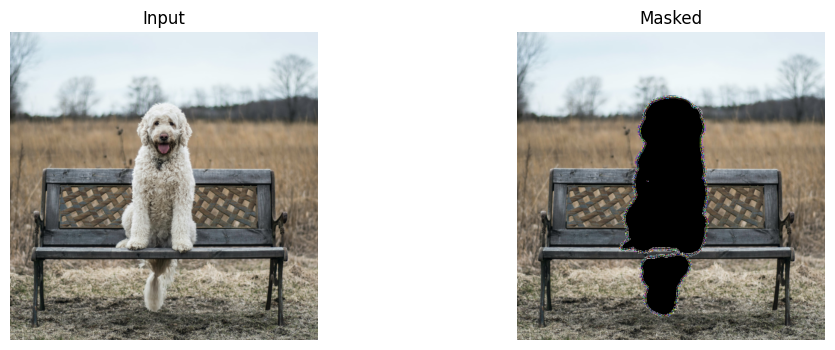

In [8]:
# download an image
image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
)
image = np.array(image)
mask_image = load_image(
     "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)
mask_image = np.array(mask_image)

text_prompt="a red panda sitting on a bench"

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')

## Canny Edge

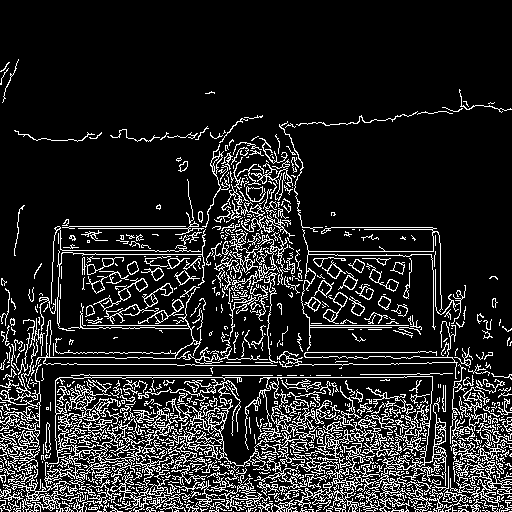

In [9]:
# get canny image
canny_image = cv2.Canny(image, 100, 200)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)

image=Image.fromarray(image)
mask_image=Image.fromarray(mask_image)
canny_image = Image.fromarray(canny_image)

canny_image

In [10]:
# load control net and stable diffusion v1-5
from diffusers import StableDiffusionControlNetInpaintPipeline  ####changed-----
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# remove following line if xformers is not installed
pipe.enable_xformers_memory_efficient_attention()

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


### Scaling image control...
In this example, `canny_image` input is actually quite hard to satisfy with the our text prompt due to a lot of local noise. In this special case, we adjust `controlnet_conditioning_scale` to `0.5` to make this guidance more subtle.

In all other examples, the default value of `controlnet_conditioning_scale` = `1.0` works rather well!

In [12]:
import os
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=canny_image,
    controlnet_conditioning_scale = 0.5,
    mask_image=mask_image
).images[0]
os.makedirs('output', exist_ok=True) ### changes-----
new_image.save('output/canny_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

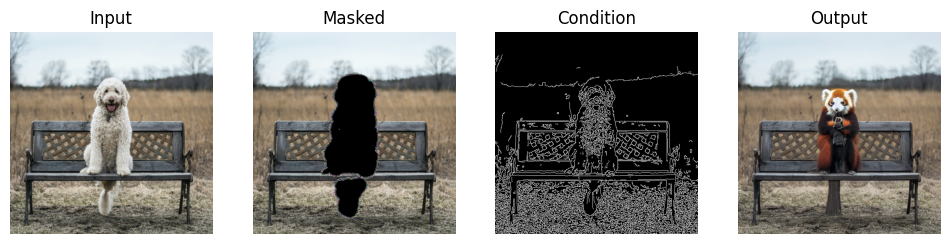

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(canny_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/canny_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Comparison: vanilla inpainting from StableDiffusion1.5

In [14]:
# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

new_image.save('output/baseline_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

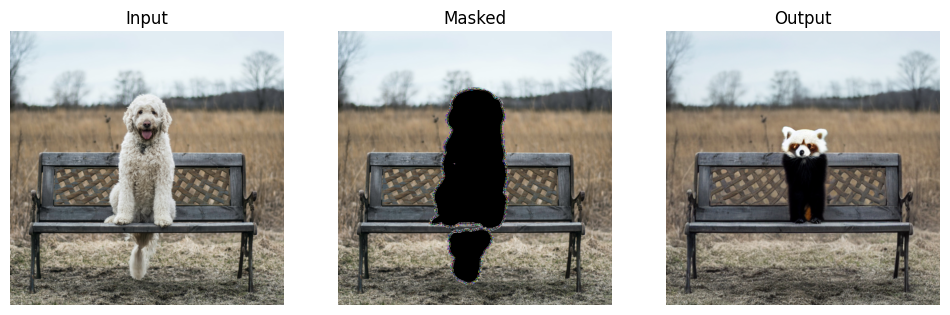

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,3,3)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/baseline_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

## Challenging Examples 🐕➡️🍔
Let's see how tuning the `controlnet_conditioning_scale` works out for a more challenging example of turning the dog into a cheeseburger!

In this case, we **demand a large semantic leap** and that requires a more subtle guide from the control image!

In [16]:
difficult_text_prompt="a big cheeseburger sitting on a bench"

  0%|          | 0/20 [00:00<?, ?it/s]

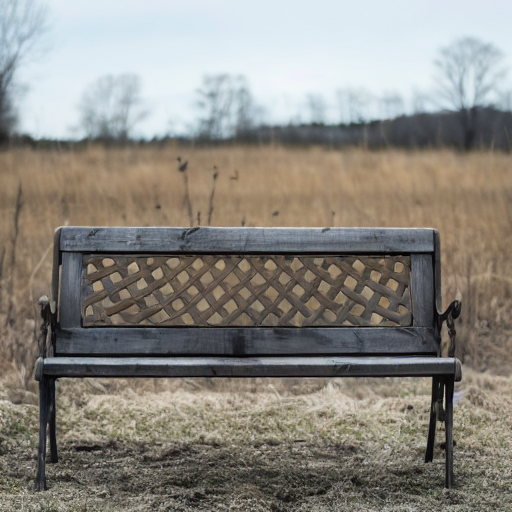

In [17]:
# First - StableDiffusion1.5 baseline (no ControlNet)

# generate image
generator = torch.manual_seed(0)
new_image = pipe_sd(
    difficult_text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    mask_image=mask_image
).images[0]

sd_output=new_image
sd_output

## HED

In [19]:
from controlnet_aux import HEDdetector

hed = HEDdetector.from_pretrained("lllyasviel/Annotators")

hed_image = hed(image)

ControlNetHED.pth:   0%|          | 0.00/29.4M [00:00<?, ?B/s]

In [20]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-hed", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [21]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=hed_image,
    mask_image=mask_image
).images[0]

new_image.save('output/hed_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

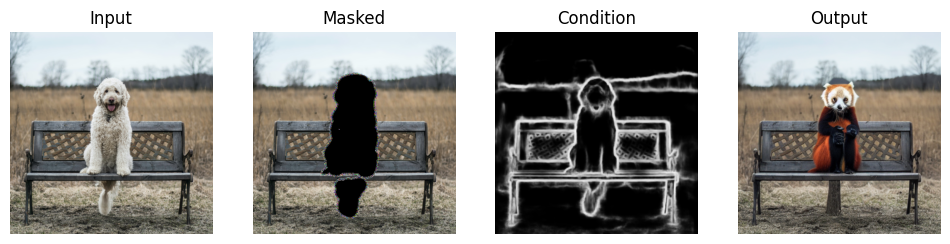

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(hed_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/hed_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Scribble

In [24]:
from controlnet_aux import HEDdetector

hed = HEDdetector.from_pretrained("lllyasviel/Annotators")

scribble_image = hed(image,scribble=True)

In [25]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-scribble", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

#pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [26]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=scribble_image,
    mask_image=mask_image
).images[0]

new_image.save('output/scribble_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

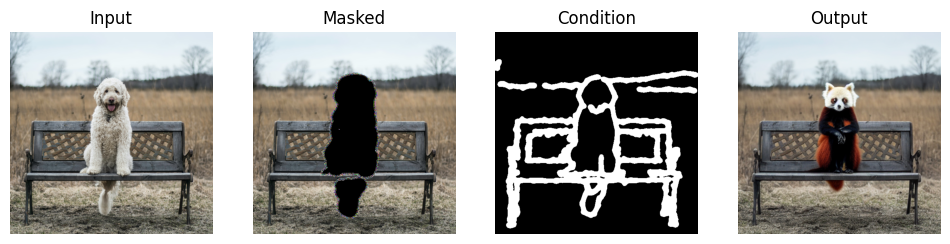

In [27]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(scribble_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/scribble_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Depth

In [28]:
from transformers import pipeline

depth_estimator = pipeline('depth-estimation')

depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate(3*[depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

In [29]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-depth", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [30]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=depth_image,
    mask_image=mask_image
).images[0]

new_image.save('output/depth_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

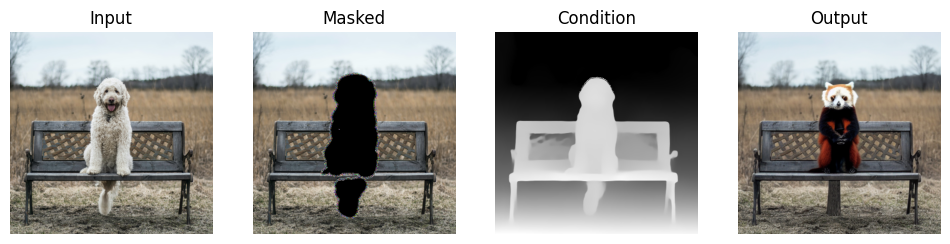

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(depth_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/depth_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Normal Map

In [32]:
import cv2

depth_estimator = pipeline("depth-estimation", model ="Intel/dpt-hybrid-midas" )

normal_image = depth_estimator(image)['predicted_depth'][0]

normal_image = normal_image.numpy()

image_depth = normal_image.copy()
image_depth -= np.min(image_depth)
image_depth /= np.max(image_depth)

bg_threhold = 0.4

x = cv2.Sobel(normal_image, cv2.CV_32F, 1, 0, ksize=3)
x[image_depth < bg_threhold] = 0

y = cv2.Sobel(normal_image, cv2.CV_32F, 0, 1, ksize=3)
y[image_depth < bg_threhold] = 0

z = np.ones_like(x) * np.pi * 2.0

normal_image = np.stack([x, y, z], axis=2)
normal_image /= np.sum(normal_image ** 2.0, axis=2, keepdims=True) ** 0.5
normal_image = (normal_image * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
normal_image = Image.fromarray(normal_image).resize((512,512))

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

In [33]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-normal", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [34]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    text_prompt,
    num_inference_steps=20,
    generator=generator,
    image=image,
    control_image=normal_image,
    mask_image=mask_image
).images[0]

new_image.save('output/normal_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

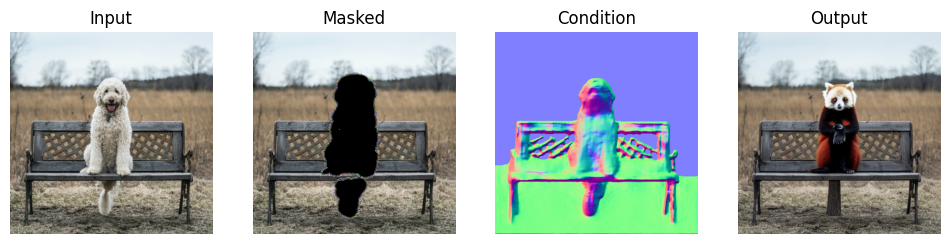

In [35]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(image))*(255-np.array(mask_image)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(normal_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/normal_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### More control input types
For these control input types, we will use a different image as in those cases, an image of the dog on the bench is not appropriate!

Let's start with a room photo...

### M-LSD

In [36]:
from controlnet_aux import MLSDdetector

mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

room_image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-mlsd/resolve/main/images/room.png")

mlsd_image = mlsd(room_image).resize(room_image.size)
#room_image = room_image

mlsd_large_512_fp32.pth:   0%|          | 0.00/6.34M [00:00<?, ?B/s]

In [37]:
room_mask=np.zeros_like(np.array(room_image))
room_mask[120:420,220:,:]=255
room_mask=Image.fromarray(room_mask)


room_mask=room_mask.resize((512,512))
mlsd_image=mlsd_image.resize((512,512))
room_image=room_image.resize((512,512))

In [38]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-mlsd", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [39]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "an image of a room with a city skyline view",
    num_inference_steps=20,
    generator=generator,
    image=room_image,
    control_image=mlsd_image,
    mask_image=room_mask
).images[0]

new_image.save('output/mlsd_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

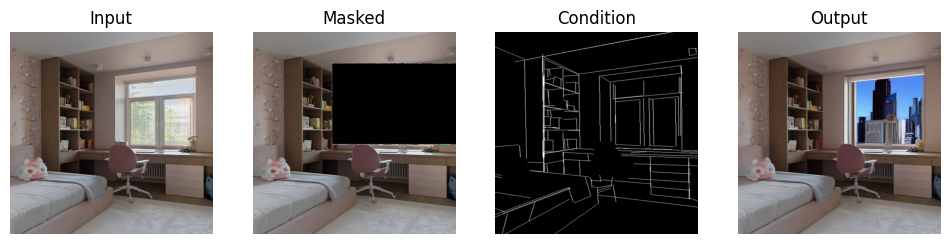

In [40]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(room_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(room_image))*(255-np.array(room_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(mlsd_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/mlsd_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### OpenPose

In [41]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [42]:
from controlnet_aux import OpenposeDetector

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

pose_real_image = load_image("https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png")

pose_image = openpose(pose_real_image)
pose_real_image=pose_real_image.resize(pose_image.size)

pose_mask=np.zeros_like(np.array(pose_image))
pose_mask[250:700,:,:]=255
pose_mask=Image.fromarray(pose_mask)

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

In [43]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a man in a knight armor",
    num_inference_steps=20,
    generator=generator,
    image=pose_real_image,
    control_image=pose_image,
    mask_image=pose_mask
).images[0]

new_image.save('output/openpose_result.png')

/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


  0%|          | 0/20 [00:00<?, ?it/s]

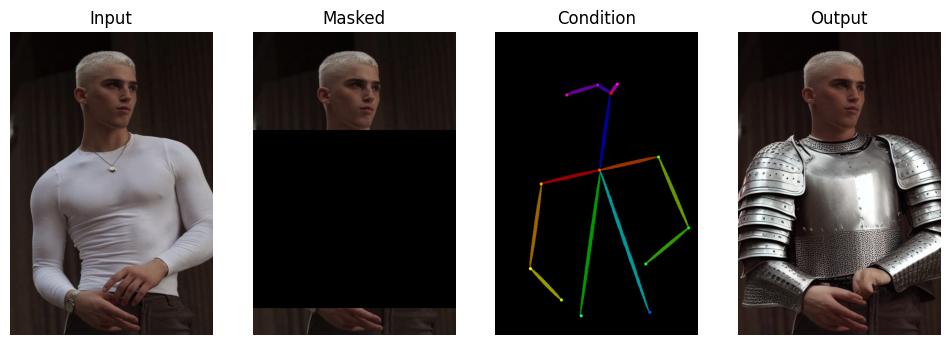

In [44]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(pose_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(pose_real_image))*(255-np.array(pose_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(pose_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')


plt.savefig('output/openpose_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )

### Segmentation Mask

In [45]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-seg", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
     "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
 )

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [46]:
house_real_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house.png")
seg_image=load_image("https://huggingface.co/lllyasviel/sd-controlnet-seg/resolve/main/images/house_seg.png")

house_mask=np.zeros((*seg_image.size,3),dtype='uint8')
house_mask[50:400,-350:,:]=255
house_mask=Image.fromarray(house_mask)

In [47]:
pipe.to('cuda')

# generate image
generator = torch.manual_seed(0)
new_image = pipe(
    "a pink eerie scary house",
    num_inference_steps=20,
    generator=generator,
    image=house_real_image,
    control_image=seg_image,
    mask_image=house_mask
).images[0]

new_image.save('output/seg_result.png')

  0%|          | 0/20 [00:00<?, ?it/s]

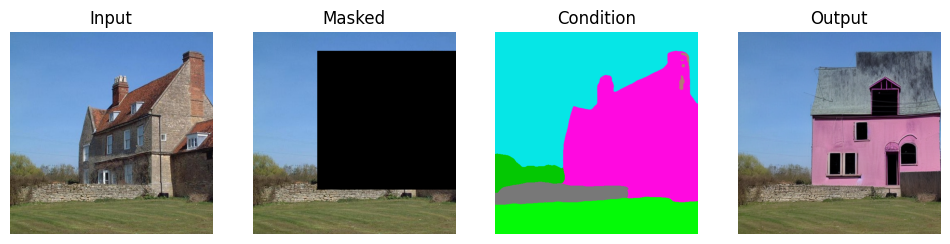

In [48]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(house_real_image)
plt.axis('off')
plt.title('Input')
plt.subplot(1,4,2)
plt.imshow((255-np.array(house_real_image))*(255-np.array(house_mask)))
plt.axis('off')
plt.title('Masked')
plt.subplot(1,4,3)
plt.imshow(seg_image)
plt.axis('off')
plt.title('Condition')
plt.subplot(1,4,4)
plt.imshow(new_image)
plt.title('Output')
plt.axis('off')

plt.savefig('output/seg_grid.png',
            dpi=200,
            bbox_inches='tight',
            pad_inches=0.0
       )